In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential,load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from IPython.display import Image
from keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input, Concatenate

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
list_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/Medbikri/Dataset/images/*.jpeg')

In [57]:
h, w = 512, 512

def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image


def decode_img(img):
  img = tf.image.decode_jpeg(img)
  return tf.image.resize(img, [h, w])

def decode_mask_img(img):
  img = tf.image.decode_jpeg(img, channels=1)
  return tf.image.resize(img, [h, w])


def process_path(file_path):
  table_mask_file_path = tf.strings.regex_replace(file_path, 'images', 'table mask')
  img = normalize(decode_img(tf.io.read_file(file_path)))
  table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_file_path)))

  return img, {"table_output" : table_mask }

In [58]:
DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train = list_ds.take(train_size)
test = list_ds.skip(train_size)

TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 5

train = train.shuffle(BUFFER_SIZE)

train = train.map(process_path,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

test = test.map(process_path)

train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("StaticRegexReplace:0", shape=(), dtype=string)


In [59]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Table Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

(512, 512, 3)


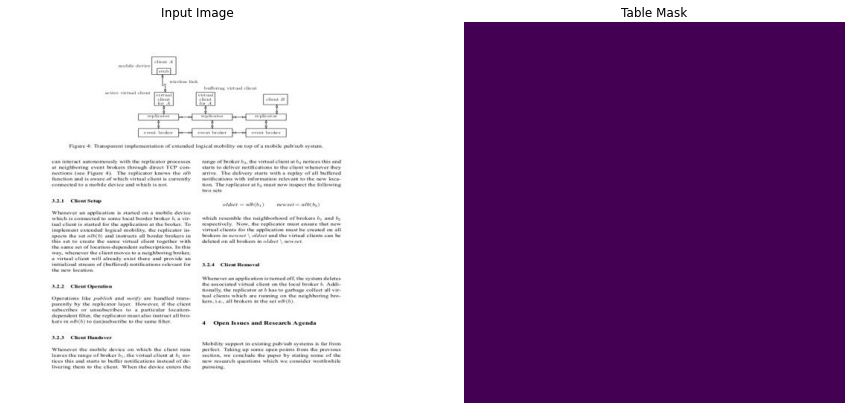

(512, 512, 3)


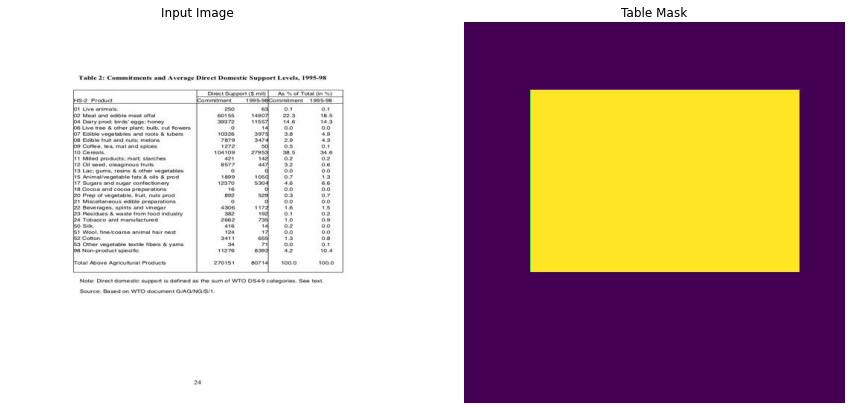

In [60]:
for image, mask  in train.take(2):
  print(image.shape)
  # print(mask.shape)
  display([image, mask['table_output']])

In [61]:
class TableNet:
  @staticmethod
  def vgg_base(inputs):
    base_model = VGG19(
        input_shape=[512, 512, 3],
        include_top=False, weights='imagenet')
    
    layer_names = ['block3_pool', 'block4_pool', 'block5_pool']
    layers = [base_model.get_layer(name).output for name in layer_names]

    pool_layers_model = Model(inputs=base_model.input, outputs=layers, name='VGG-19')
    pool_layers_model.trainable = False

    return pool_layers_model(inputs)

  @staticmethod
  def build_table_decoder(inputs, pool3, pool4):
    x = Conv2D(512, (1, 1), activation = 'relu', name='conv7_table')(inputs)
    x = UpSampling2D(size=(2, 2))(x)

    concatenated = Concatenate()([x, pool4])

    x = UpSampling2D(size=(2,2))(concatenated)
    
    concatenated = Concatenate()([x, pool3])

    x = UpSampling2D(size=(2,2))(concatenated)
    x = UpSampling2D(size=(2,2))(x)

    last = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same', name='table_output') 
    x = last(x)
    return x
  
  @staticmethod
  def build():
    inputShape = (512, 512, 3)

    inputs = Input(shape=inputShape, name='input')

    pool_layers = TableNet.vgg_base(inputs)

    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(pool_layers[-1])
    x = Dropout(0.8, name = 'block6_dropout1')(x)
    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
    x = Dropout(0.8, name = 'block6_dropout2')(x)
    
    table_mask = TableNet.build_table_decoder(x, pool_layers[0], pool_layers[1])

    model = Model(			
              inputs=inputs,
			        outputs=table_mask,
			        name="TableNet")
    
    return model

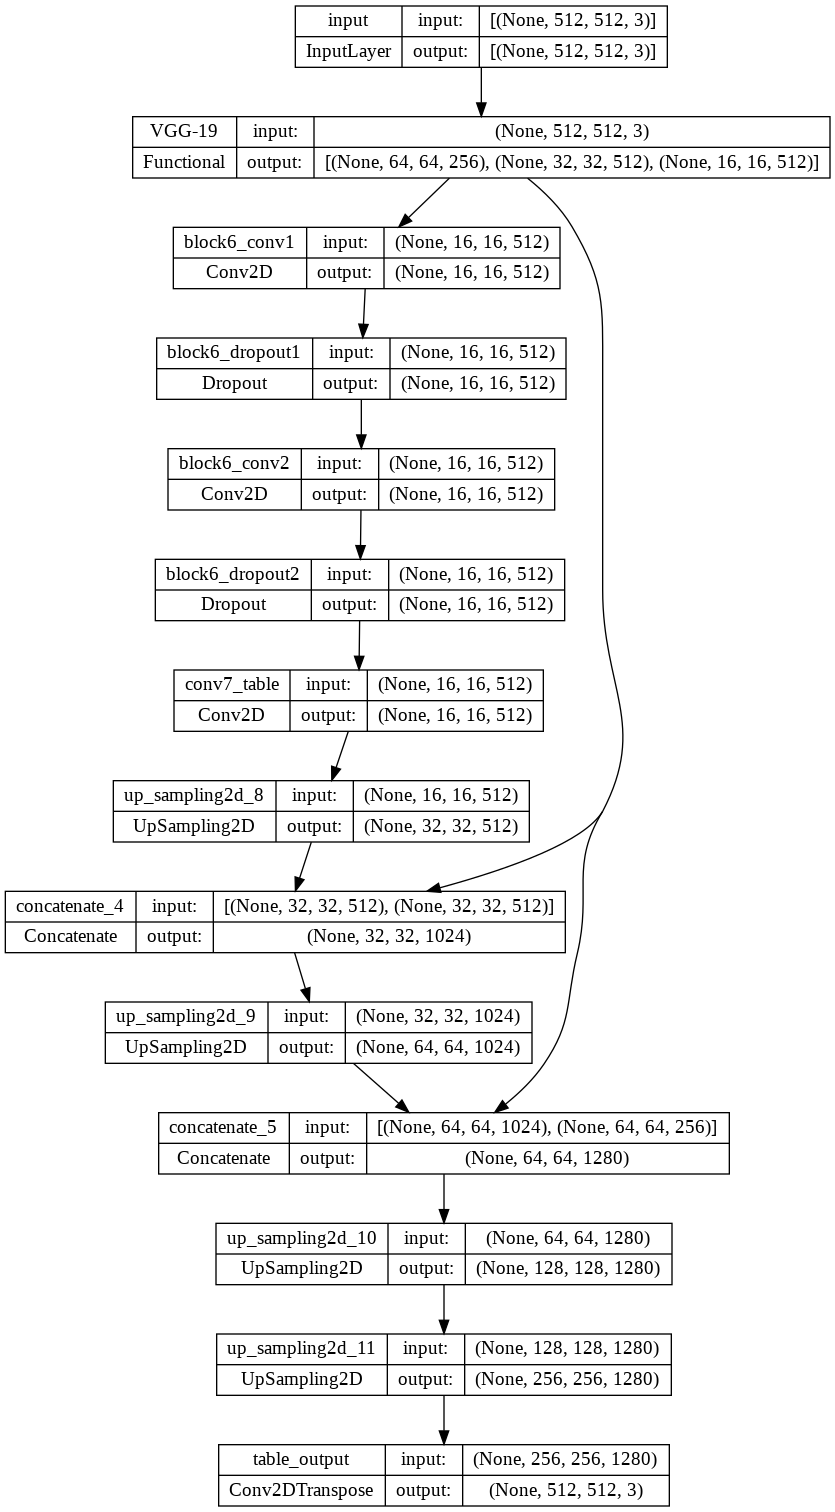

In [62]:
model = TableNet.build()
tf.keras.utils.plot_model(model, show_shapes=True)

In [63]:
losses = {
	"table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}

lossWeights = {"table_output": 1.0}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

In [64]:
def create_mask(pred_mask1):
  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = pred_mask1[..., tf.newaxis]
  return pred_mask1[0]


In [65]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask1 = image, mask['table_output']

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, (mask1) in dataset.take(num):
      pred_mask1= model.predict(image, verbose=1)
      table_mask= create_mask(pred_mask1)
      
      display([image[0], table_mask])
  else:
    pred_mask1 = model.predict(sample_image, verbose=1)
    table_mask= create_mask(pred_mask1)

    display([sample_image[0], table_mask])

In [67]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )

early_stoping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1,
    )

In [83]:
EPOCHS = 1000
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[model_checkpoint])

Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9539
Epoch 1: val_loss did not improve from 0.13457
5/5 [==============================] - 2s 349ms/step - loss: 0.1494 - accuracy: 0.9539 - val_loss: 0.1747 - val_accuracy: 0.9393
Epoch 2/1000
5/5 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9383
Epoch 2: val_loss did not improve from 0.13457
5/5 [==============================] - 2s 348ms/step - loss: 0.2120 - accuracy: 0.9383 - val_loss: 0.2349 - val_accuracy: 0.9117
Epoch 3/1000
5/5 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9790
Epoch 3: val_loss did not improve from 0.13457
5/5 [==============================] - 2s 347ms/step - loss: 0.0648 - accuracy: 0.9790 - val_loss: 0.1693 - val_accuracy: 0.9459
Epoch 4/1000
5/5 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9613
Epoch 4: val_loss did not improve from 0.13457
5/5 [==============================] - 2s 348ms/s

5/5 [==============================] - 5s 1s/step - loss: 0.2164 - accuracy: 0.9171 - val_loss: 0.1242 - val_accuracy: 0.9574
Epoch 6/1000
5/5 [==============================] - ETA: 0s - loss: 0.1714 - accuracy: 0.9329
Epoch 6: val_loss did not improve from 0.12416
5/5 [==============================] - 2s 349ms/step - loss: 0.1714 - accuracy: 0.9329 - val_loss: 0.2382 - val_accuracy: 0.9122
Epoch 7/1000
5/5 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9670
Epoch 7: val_loss did not improve from 0.12416
5/5 [==============================] - 2s 350ms/step - loss: 0.0921 - accuracy: 0.9670 - val_loss: 0.2383 - val_accuracy: 0.9136
Epoch 8/1000
5/5 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8992
Epoch 8: val_loss did not improve from 0.12416
5/5 [==============================] - 2s 350ms/step - loss: 0.3145 - accuracy: 0.8992 - val_loss: 0.2287 - val_accuracy: 0.9181
Epoch 9/1000
5/5 [==============================] - ETA: 0s - lo

5/5 [==============================] - 7s 2s/step - loss: 0.1535 - accuracy: 0.9410 - val_loss: 0.1195 - val_accuracy: 0.9579
Epoch 31/1000
5/5 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9020
Epoch 31: val_loss did not improve from 0.11950
5/5 [==============================] - 2s 363ms/step - loss: 0.2405 - accuracy: 0.9020 - val_loss: 0.2094 - val_accuracy: 0.9247
Epoch 32/1000
5/5 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9765
Epoch 32: val_loss did not improve from 0.11950
5/5 [==============================] - 2s 362ms/step - loss: 0.0707 - accuracy: 0.9765 - val_loss: 0.2148 - val_accuracy: 0.9273
Epoch 33/1000
5/5 [==============================] - ETA: 0s - loss: 0.0969 - accuracy: 0.9668
Epoch 33: val_loss did not improve from 0.11950
5/5 [==============================] - 2s 363ms/step - loss: 0.0969 - accuracy: 0.9668 - val_loss: 0.1223 - val_accuracy: 0.9536
Epoch 34/1000
5/5 [==============================] - ETA: 

5/5 [==============================] - 5s 1s/step - loss: 0.0993 - accuracy: 0.9602 - val_loss: 0.1064 - val_accuracy: 0.9606
Epoch 52/1000
5/5 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9800
Epoch 52: val_loss did not improve from 0.10641
5/5 [==============================] - 2s 377ms/step - loss: 0.0601 - accuracy: 0.9800 - val_loss: 0.2051 - val_accuracy: 0.9215
Epoch 53/1000
5/5 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9719
Epoch 53: val_loss did not improve from 0.10641
5/5 [==============================] - 2s 372ms/step - loss: 0.0765 - accuracy: 0.9719 - val_loss: 0.1700 - val_accuracy: 0.9426
Epoch 54/1000
5/5 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.9206
Epoch 54: val_loss did not improve from 0.10641
5/5 [==============================] - 2s 373ms/step - loss: 0.2916 - accuracy: 0.9206 - val_loss: 0.2015 - val_accuracy: 0.9269
Epoch 55/1000
5/5 [==============================] - ETA: 

5/5 [==============================] - 5s 1s/step - loss: 0.0828 - accuracy: 0.9689 - val_loss: 0.0964 - val_accuracy: 0.9639
Epoch 81/1000
5/5 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9568
Epoch 81: val_loss did not improve from 0.09642
5/5 [==============================] - 2s 372ms/step - loss: 0.1161 - accuracy: 0.9568 - val_loss: 0.1704 - val_accuracy: 0.9379
Epoch 82/1000
5/5 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.8746
Epoch 82: val_loss did not improve from 0.09642
5/5 [==============================] - 2s 369ms/step - loss: 0.3573 - accuracy: 0.8746 - val_loss: 0.2073 - val_accuracy: 0.9248
Epoch 83/1000
5/5 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9269
Epoch 83: val_loss did not improve from 0.09642
5/5 [==============================] - 2s 370ms/step - loss: 0.1853 - accuracy: 0.9269 - val_loss: 0.2542 - val_accuracy: 0.9011
Epoch 84/1000
5/5 [==============================] - ETA: 

5/5 [==============================] - 6s 2s/step - loss: 0.1364 - accuracy: 0.9422 - val_loss: 0.0919 - val_accuracy: 0.9691
Epoch 113/1000
5/5 [==============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.9390
Epoch 113: val_loss did not improve from 0.09187
5/5 [==============================] - 2s 375ms/step - loss: 0.1865 - accuracy: 0.9390 - val_loss: 0.2291 - val_accuracy: 0.9257
Epoch 114/1000
5/5 [==============================] - ETA: 0s - loss: 0.2378 - accuracy: 0.9269
Epoch 114: val_loss did not improve from 0.09187
5/5 [==============================] - 2s 374ms/step - loss: 0.2378 - accuracy: 0.9269 - val_loss: 0.3583 - val_accuracy: 0.8604
Epoch 115/1000
5/5 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9306
Epoch 115: val_loss did not improve from 0.09187
5/5 [==============================] - 2s 375ms/step - loss: 0.2112 - accuracy: 0.9306 - val_loss: 0.1720 - val_accuracy: 0.9349
Epoch 116/1000
5/5 [==============================] 

5/5 [==============================] - 5s 1s/step - loss: 0.0451 - accuracy: 0.9822 - val_loss: 0.0752 - val_accuracy: 0.9729
Epoch 134/1000
5/5 [==============================] - ETA: 0s - loss: 0.1176 - accuracy: 0.9596
Epoch 134: val_loss did not improve from 0.07518
5/5 [==============================] - 2s 383ms/step - loss: 0.1176 - accuracy: 0.9596 - val_loss: 0.1326 - val_accuracy: 0.9440
Epoch 135/1000
5/5 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9720
Epoch 135: val_loss did not improve from 0.07518
5/5 [==============================] - 2s 374ms/step - loss: 0.0762 - accuracy: 0.9720 - val_loss: 0.1268 - val_accuracy: 0.9566
Epoch 136/1000
5/5 [==============================] - ETA: 0s - loss: 0.2859 - accuracy: 0.8900
Epoch 136: val_loss did not improve from 0.07518
5/5 [==============================] - 2s 373ms/step - loss: 0.2859 - accuracy: 0.8900 - val_loss: 0.2781 - val_accuracy: 0.8965
Epoch 137/1000
5/5 [==============================] 

5/5 [==============================] - 5s 1s/step - loss: 0.0807 - accuracy: 0.9685 - val_loss: 0.0635 - val_accuracy: 0.9767
Epoch 148/1000
5/5 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9559
Epoch 148: val_loss did not improve from 0.06349
5/5 [==============================] - 2s 377ms/step - loss: 0.0998 - accuracy: 0.9559 - val_loss: 0.0800 - val_accuracy: 0.9743
Epoch 149/1000
5/5 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.9348
Epoch 149: val_loss did not improve from 0.06349
5/5 [==============================] - 2s 374ms/step - loss: 0.1784 - accuracy: 0.9348 - val_loss: 0.2272 - val_accuracy: 0.9256
Epoch 150/1000
5/5 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9774
Epoch 150: val_loss did not improve from 0.06349
5/5 [==============================] - 2s 375ms/step - loss: 0.0634 - accuracy: 0.9774 - val_loss: 0.1514 - val_accuracy: 0.9458
Epoch 151/1000
5/5 [==============================] 

5/5 [==============================] - 5s 1s/step - loss: 0.1490 - accuracy: 0.9380 - val_loss: 0.0568 - val_accuracy: 0.9819
Epoch 247/1000
5/5 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9802
Epoch 247: val_loss did not improve from 0.05676
5/5 [==============================] - 2s 374ms/step - loss: 0.0563 - accuracy: 0.9802 - val_loss: 0.1222 - val_accuracy: 0.9517
Epoch 248/1000
5/5 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9234
Epoch 248: val_loss did not improve from 0.05676
5/5 [==============================] - 2s 375ms/step - loss: 0.1900 - accuracy: 0.9234 - val_loss: 0.2037 - val_accuracy: 0.9219
Epoch 249/1000
5/5 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9397
Epoch 249: val_loss did not improve from 0.05676
5/5 [==============================] - 2s 375ms/step - loss: 0.1478 - accuracy: 0.9397 - val_loss: 0.1748 - val_accuracy: 0.9365
Epoch 250/1000
5/5 [==============================] 

5/5 [==============================] - 5s 1s/step - loss: 0.0727 - accuracy: 0.9733 - val_loss: 0.0439 - val_accuracy: 0.9851
Epoch 296/1000
5/5 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9720
Epoch 296: val_loss did not improve from 0.04392
5/5 [==============================] - 2s 369ms/step - loss: 0.0679 - accuracy: 0.9720 - val_loss: 0.1290 - val_accuracy: 0.9562
Epoch 297/1000
5/5 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9804
Epoch 297: val_loss did not improve from 0.04392
5/5 [==============================] - 2s 372ms/step - loss: 0.0468 - accuracy: 0.9804 - val_loss: 0.1209 - val_accuracy: 0.9610
Epoch 298/1000
5/5 [==============================] - ETA: 0s - loss: 0.2836 - accuracy: 0.9167
Epoch 298: val_loss did not improve from 0.04392
5/5 [==============================] - 2s 374ms/step - loss: 0.2836 - accuracy: 0.9167 - val_loss: 0.0871 - val_accuracy: 0.9640
Epoch 299/1000
5/5 [==============================] 

5/5 [==============================] - 5s 1s/step - loss: 0.0990 - accuracy: 0.9663 - val_loss: 0.0402 - val_accuracy: 0.9851
Epoch 330/1000
5/5 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9768
Epoch 330: val_loss did not improve from 0.04015
5/5 [==============================] - 2s 377ms/step - loss: 0.0482 - accuracy: 0.9768 - val_loss: 0.1211 - val_accuracy: 0.9531
Epoch 331/1000
5/5 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9261
Epoch 331: val_loss did not improve from 0.04015
5/5 [==============================] - 2s 374ms/step - loss: 0.1866 - accuracy: 0.9261 - val_loss: 0.1516 - val_accuracy: 0.9415
Epoch 332/1000
5/5 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9591
Epoch 332: val_loss did not improve from 0.04015
5/5 [==============================] - 2s 372ms/step - loss: 0.1017 - accuracy: 0.9591 - val_loss: 0.1540 - val_accuracy: 0.9429
Epoch 333/1000
5/5 [==============================] 

5/5 [==============================] - 5s 1s/step - loss: 0.2022 - accuracy: 0.9516 - val_loss: 0.0382 - val_accuracy: 0.9823
Epoch 641/1000
5/5 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.9087
Epoch 641: val_loss did not improve from 0.03816
5/5 [==============================] - 2s 378ms/step - loss: 0.1968 - accuracy: 0.9087 - val_loss: 0.1110 - val_accuracy: 0.9592
Epoch 642/1000
5/5 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9602
Epoch 642: val_loss did not improve from 0.03816
5/5 [==============================] - 2s 375ms/step - loss: 0.1273 - accuracy: 0.9602 - val_loss: 0.1410 - val_accuracy: 0.9484
Epoch 643/1000
5/5 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9795
Epoch 643: val_loss did not improve from 0.03816
5/5 [==============================] - 2s 375ms/step - loss: 0.0812 - accuracy: 0.9795 - val_loss: 0.0647 - val_accuracy: 0.9768
Epoch 644/1000
5/5 [==============================] 

1/1 [==============================] - 0s 25ms/step


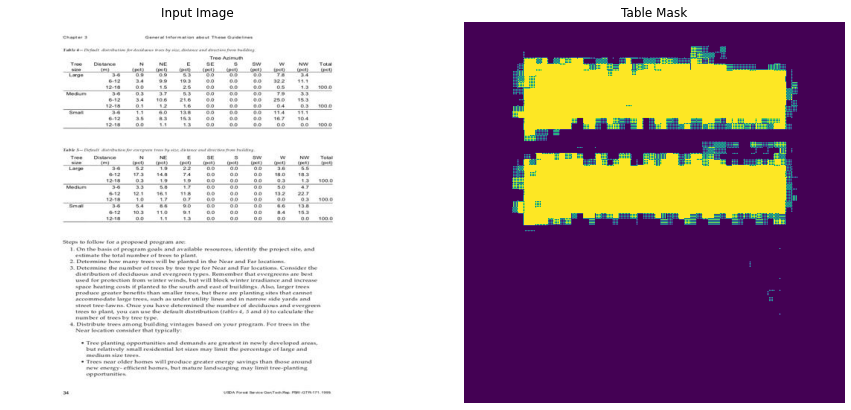

1/1 [==============================] - 0s 20ms/step


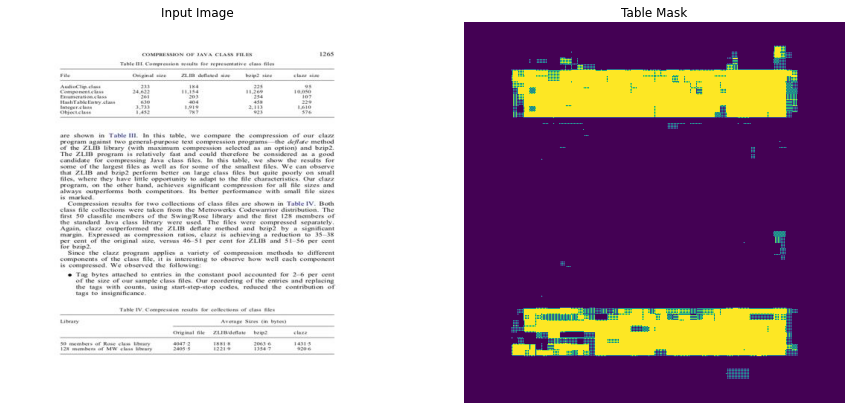

1/1 [==============================] - 0s 22ms/step


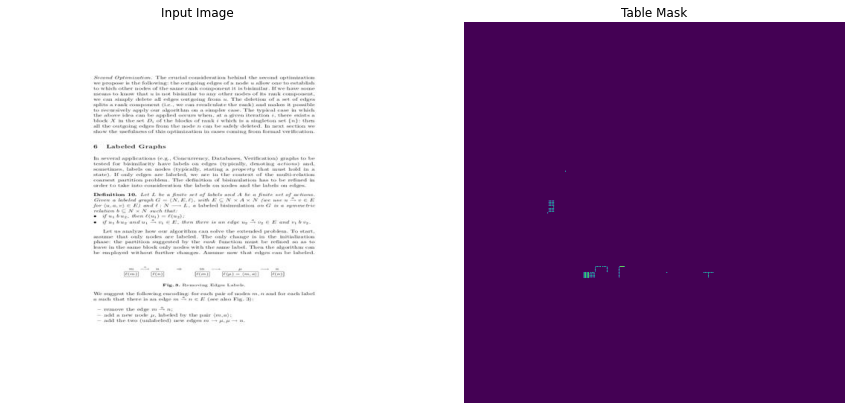

1/1 [==============================] - 0s 20ms/step


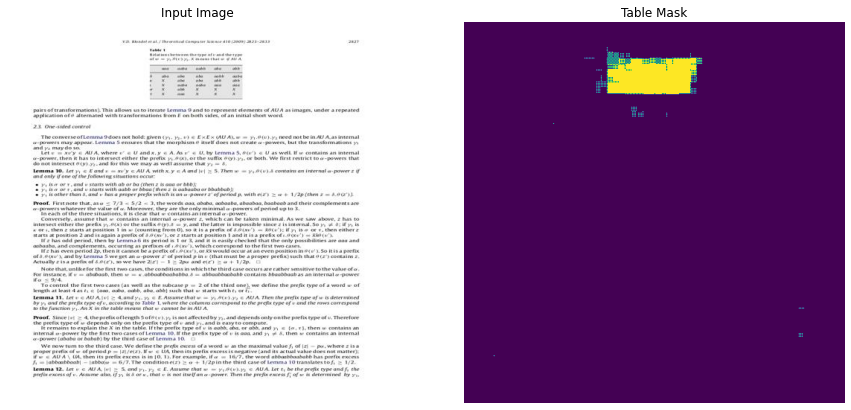

1/1 [==============================] - 0s 20ms/step


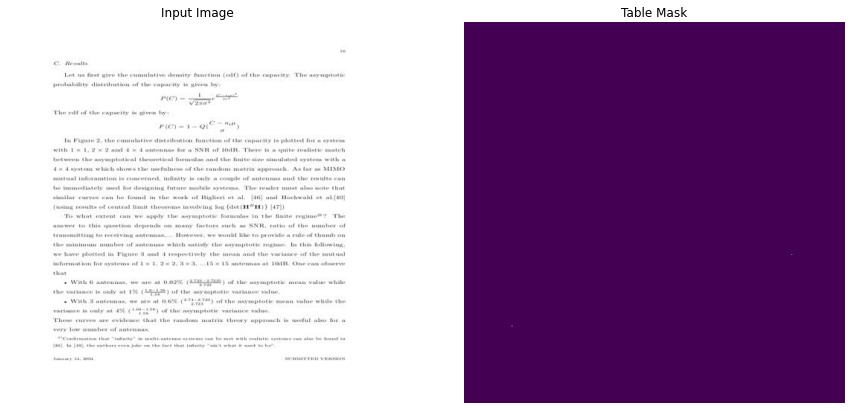

In [84]:
show_predictions(train_dataset, 5)

In [85]:
model.save('model3')

In [87]:
!zip -r model3.zip model3/

  adding: model3/ (stored 0%)
  adding: model3/saved_model.pb (deflated 90%)
  adding: model3/variables/ (stored 0%)
  adding: model3/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model3/variables/variables.index (deflated 69%)
  adding: model3/assets/ (stored 0%)
  adding: model3/keras_metadata.pb (deflated 96%)


In [88]:
!cp model3.zip '/content/drive/My Drive/Medbikri/'